In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gymnasium as gym
env = gym.make("ALE/KungFuMaster-v5")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
def transform(state):
    return torch.from_numpy(state).permute(2, 1, 0).float() / 255.0

def rollout(env, agent, max_steps=1000):
    result = []
    state, _ = env.reset()
    state = transform(state)
    for _ in range(max_steps):
        action = agent(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        result.append((state, action, reward))
        state = transform(next_state)
        if terminated or truncated:
            break
    return result

def batches(env, agent, batch_size=32, num_batches=100, max_steps=1000, reward_discount=0.99):
    games = []
    gamea = []
    gamer = []
    while num_batches > 0:
        while len(games) < batch_size:
            game = rollout(env, agent, max_steps)
            # score using discounted rewards
            acc_reward = 0
            for i in range(len(game) - 1, -1, -1):
                acc_reward = game[i][2] + reward_discount * acc_reward
                games.append(game[i][0])
                gamea.append(game[i][1])
                gamer.append(acc_reward)

        yield games[:batch_size], gamea[:batch_size], gamer[:batch_size]
        games = games[batch_size:]
        gamea = gamea[batch_size:]
        gamer = gamer[batch_size:]
        num_batches -= 1

In [5]:
class AtariNet(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        conv_out = self.conv(x)
        # flatten each sample in the batch
        conv_out = conv_out.view(x.shape[0], -1) if len(x.shape) == 4 else conv_out.flatten()
        pred = self.fc(conv_out)
        return pred

Epoch 0 took 61.81s, reward: 81.14, loss: 207.90
Epoch 1 took 62.76s, reward: 136.49, loss: 278.38
Epoch 2 took 54.31s, reward: 238.97, loss: 383.34
Epoch 3 took 51.95s, reward: 246.16, loss: 403.65
Epoch 4 took 51.93s, reward: 212.37, loss: 369.19
Epoch 5 took 51.94s, reward: 215.44, loss: 395.14
Epoch 6 took 51.95s, reward: 227.22, loss: 433.21
Epoch 7 took 51.61s, reward: 187.48, loss: 403.98
Epoch 8 took 51.19s, reward: 238.23, loss: 474.33
Epoch 9 took 51.90s, reward: 279.40, loss: 497.79
Epoch 10 took 51.33s, reward: 291.85, loss: 551.69
Epoch 11 took 51.38s, reward: 313.62, loss: 566.61
Epoch 12 took 51.15s, reward: 307.67, loss: 535.57
Epoch 13 took 51.21s, reward: 301.62, loss: 532.25
Epoch 14 took 51.54s, reward: 299.55, loss: 502.11
Epoch 15 took 51.19s, reward: 303.51, loss: 497.12
Epoch 16 took 51.54s, reward: 333.47, loss: 515.42
Epoch 17 took 51.26s, reward: 335.13, loss: 513.44
Epoch 18 took 51.77s, reward: 302.31, loss: 477.95
Epoch 19 took 51.37s, reward: 303.25, loss

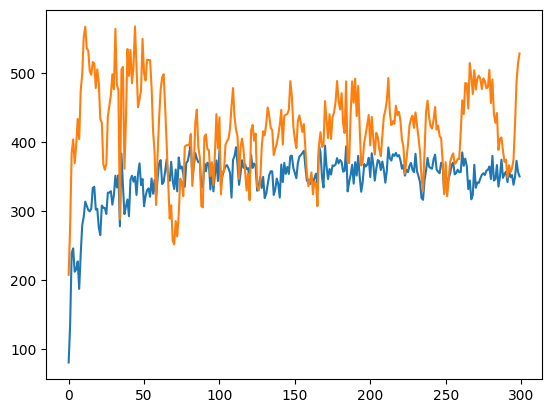

In [6]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AtariNet((3, 160, 210), env.action_space.n)
net = net.to(device)

def agent(state):
    state = state.to(device)
    pred = net(state)
    assert(len(pred.shape) == 1)
    prob = F.softmax(pred, dim=0)
    act = torch.multinomial(prob, 1)
    return act.item() # pred.argmax().item()

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

num_epochs = 300
num_batches = 400
batch_size = 128

epoch_rewards = []
epoch_losses = []

for epoch in range(num_epochs):
    epoch_reward = 0
    epoch_loss = 0
    epoch_start = time.time()

    for bs, ba, br in batches(env, agent, batch_size=batch_size, num_batches=num_batches):
        bs = torch.stack(bs)
        ba = torch.tensor(ba, dtype=torch.long)
        br = torch.tensor(br, dtype=torch.float)

        bs, ba, br = bs.to(device), ba.to(device), br.to(device)

        pred = net(bs)
        loss = (F.cross_entropy(pred, ba, reduction='none') * br).mean()

        epoch_reward += br.mean().item()
        epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_reward /= num_batches
    epoch_loss /= num_batches

    print(f'Epoch {epoch} took {time.time() - epoch_start:.2f}s, reward: {epoch_reward:.2f}, loss: {epoch_loss:.2f}')

    epoch_rewards.append(epoch_reward)
    epoch_losses.append(epoch_loss)

    torch.save(net.state_dict(), 'kungfu.pth')

plt.plot(epoch_rewards)
plt.plot(epoch_losses)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = AtariNet((3, 160, 210), env.action_space.n).to(device)
net.load_state_dict(torch.load('kungfu.pth', weights_only=True))

testenv = gym.make("ALE/KungFuMaster-v5", render_mode="human")
observation, info = testenv.reset()

while True:
    action = agent(transform(observation))
    observation, reward, terminated, truncated, info = testenv.step(action)

    if terminated or truncated:
        break

testenv.close()

/home/zeux/.local/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
